In [300]:
## Basic imports for worling with paths
import os
import sys

## Custom package modules
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import anal_foc_diff_fields as afi
from misloc_mispol_package.optics import diffraction_int as diffi
    
import numpy as np
## For fitting
import scipy.optimize as opt
## For loading matlab files 
import scipy.io as sio
from scipy.constants import physical_constants

## Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)

## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable
## Instructions for adding colorbar to axes 
#     ## Add colorbar
#     divider = make_axes_locatable(axs[ax_idx])
#     cax1 = divider.append_axes("right", size="5%", pad=0.05)
#     fig.colorbar(img1, cax=cax1)

## Useful unit conversion
m_per_nm = fit.m_per_nm

In [117]:
import scipy.constants as con
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
nm = 1e-7
## DEFINE BACKGROUND FOR FITS
eps_b = 1.778

Lets start with the sphere data Curly sent me

In [221]:
path_to_data = (
    "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"+
    "from_Biteen_group/high_SNR_nanosphere_experiments/")

Text(0.5, 0, 'eV')

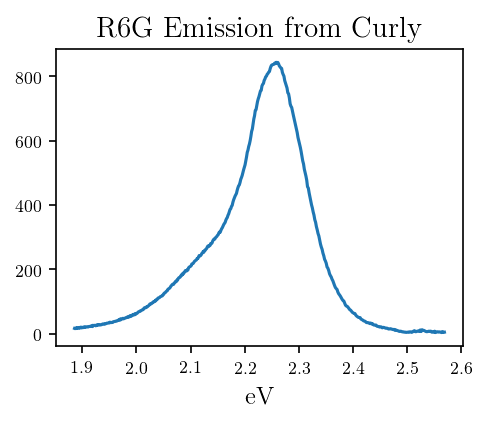

In [32]:
R6G_spectrum = sio.loadmat(os.path.join(path_to_data, "R6G_spectrum.mat"))
# R6G_spectrum.keys()

R6G_spectrum = R6G_spectrum["bdpr6g"]
# R6G_spectrum.shape

# R6G_spectrum[1,:5]
plt.figure(dpi=150)
plt.plot(1240/R6G_spectrum[0], R6G_spectrum[1])
plt.title('R6G Emission from Curly')
plt.xlabel('eV')

Fit 

In [38]:
## Assume isotropic background of water
eps_b = 1.778

In [43]:
def mol_spec_model(
    hw, 
#     eps_b,
#     mass, 
    hw_res, 
    hbargamma_nr,  
    ):
    
    gamma = hbargamma_nr/hbar

    alpha = cp.sparse_polarizability_tensor(
        cp.fluorophore_mass(70000, gamma), 
        w_res=hw_res/hbar, 
        w=hw/hbar, 
        gamma_nr=gamma, 
        a=0, 
        eps_inf=0, 
        eps_b=eps_b,
        )
    
    sigma = cp.sigma_prefactor(hw/hbar, eps_b) * (
        np.abs(alpha[0,0])**2.
        )
    return sigma

In [44]:
hbarws = 1240/R6G_spectrum[0]


In [81]:
#+++++++++++++++++++++++++++++++++++++++++++++

def mol_cost_func(params, *args):
    x=args[0]
    y=args[1]

#     eps_inf=params[0]
#     hw_res=params[0]
#     hgamma=params[1]
    amp = params[-1]
    
    params = params[:-1]
    
#     print(params)
    yfit = mol_spec_model(x,*params)
    
    y_normed = y/y.max()
    yfit_normed = yfit/yfit.max()*amp

    return (y_normed-yfit_normed).ravel()

def two_peak_mol_cost_func(params, *args):
    x=args[0]
    y=args[1]

#     eps_inf=params[0]
#     hw_res=params[0]
#     hgamma=params[1]
    amp1 = params[-1]
    amp2 = params[-2]
    
    params = params[:-2]
    
#     print(params)
    yfit1 = mol_spec_model(x,*params[:2])
    yfit2 = mol_spec_model(x,*params[2:])
    
    y_normed = y/y.max()
    yfit_normed = (yfit1/yfit1.max()*amp1) + (yfit2/yfit2.max()*amp2)

    return (y_normed-yfit_normed).ravel()

#+++++++++++++++++++++++++++++++++++++++++++++

### Try fitting 1 oscillator to mol spectrum

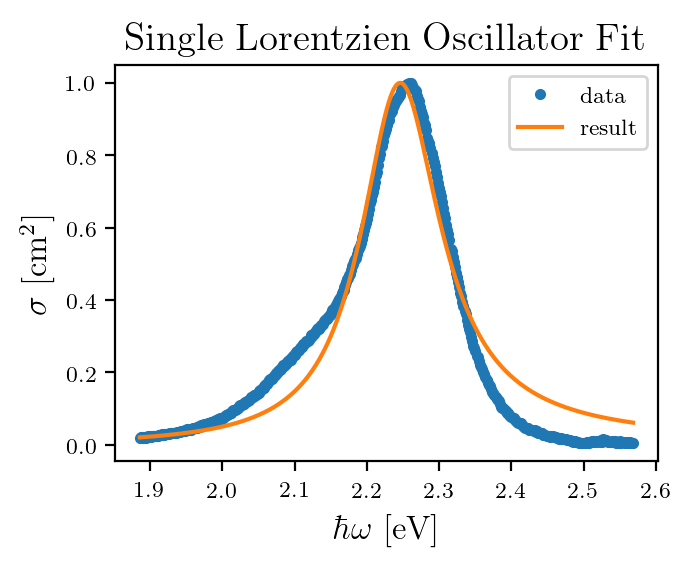

In [110]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([
    2.25, .05,
#     .25, .05, 0.9, 
    0.9])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[hbarws, R6G_spectrum[1],]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    mol_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = mol_spec_model(hbarws, *result['x'][:-1])

norm_fit_result = fit_result/fit_result.max()

# higher_damp = result['x'].copy()
# higher_damp[2] = 0.22
# higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(hbarws, *higher_damp)

data = R6G_spectrum[1]
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.')
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(hbarws, norm_fit_result,label='result', ls='-')

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Single Lorentzien Oscillator Fit')
plt.legend()

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()

In [108]:
result['x']

array([2.24412138, 0.1341578 , 1.00626086])

### Try fitting two oscillators to the mol spectrum

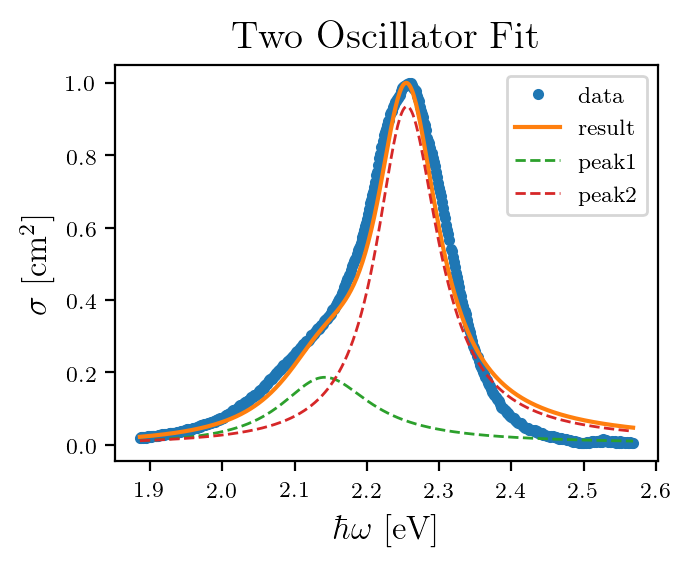

In [111]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([2.25, .05, .25, .05, 0.9, 0.9])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[hbarws, R6G_spectrum[1],]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    two_peak_mol_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
# fit_result = mol_spec_model(hbarws, *result['x'][:-1])
fit_result = (
    mol_spec_model(hbarws, *result['x'][:2]) * result['x'][-1]
    +
    mol_spec_model(hbarws, *result['x'][2:-2]) * result['x'][-2]
)

norm_fit_result = fit_result/fit_result.max()

peak1 = mol_spec_model(hbarws, *result['x'][:2]) * result['x'][-1]

normed_peak1 = peak1/fit_result.max()

peak2 = mol_spec_model(hbarws, *result['x'][2:-2]) * result['x'][-2]

normed_peak2 = peak2/fit_result.max()


# higher_damp = result['x'].copy()
# higher_damp[2] = 0.22
# higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(hbarws, *higher_damp)

data = R6G_spectrum[1]
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.')
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(hbarws, norm_fit_result,label='result', ls='-')
plt.plot(hbarws, normed_peak1, ls='--', lw=1, label='peak1')
plt.plot(hbarws, normed_peak2, ls='--', lw=1, label='peak2')

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Two Oscillator Fit')
plt.legend()

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()

In [106]:
result['x']

array([2.13904734, 0.1535714 , 2.25425592, 0.10481735, 0.97681753,
       0.21590805])

#### Fit plasmon spectra

Text(0.5, 0, '$\\lambda$ [nm]')

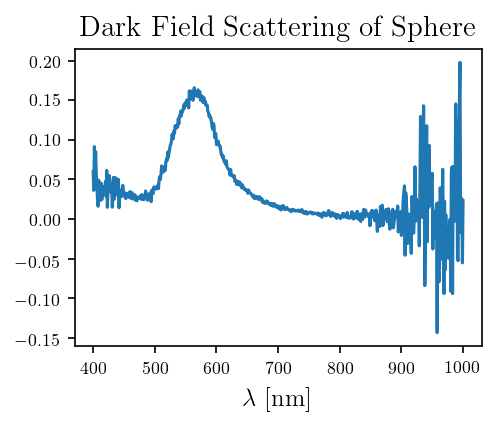

In [115]:
AuNP_DFSpec = sio.loadmat(os.path.join(path_to_data, "AuNP_DFSpec.mat"))
AuNP_DFSpec.keys()

AuNP_DFSpec = np.hstack((AuNP_DFSpec['wl'], AuNP_DFSpec['DF'][:, None,0])).T

plt.figure(dpi=150)
plt.plot(AuNP_DFSpec[0], AuNP_DFSpec[1])
plt.title("Dark Field Scattering of Sphere")
plt.xlabel(r'$\lambda$ [nm]')

##### Cropping off noisy bs

Text(0.5, 0, '$\\lambda$ [nm]')

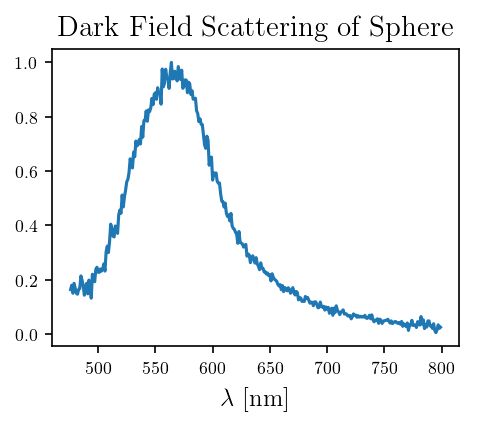

In [116]:
AuNP_DFSpec=AuNP_DFSpec[:, np.argwhere(np.logical_and(AuNP_DFSpec[0]>475, AuNP_DFSpec[0]<800))]

plt.figure(dpi=150)
plt.plot(
    AuNP_DFSpec[0], 
    AuNP_DFSpec[1]/np.max(AuNP_DFSpec[1])
    )
plt.title("Dark Field Scattering of Sphere")
plt.xlabel(r'$\lambda$ [nm]')

Fit

In [118]:
hbarws = 1240/AuNP_DFSpec[0]

## ----

def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, a):
    return cp.sigma_scat_ret_sphere(
        hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, eps_b, a*nm)
# def ret_fit_scat_2(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
#     return cp.short_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, eps_b, a_1*nm, a_2*nm)*1e10

In [122]:
#+++++++++++++++++++++++++++++++++++++++++++++

def cost_func(params, *args):
    x=args[0]
    y=args[1]

#     eps_inf=params[0]
#     w_p=params[1]
#     gamma=params[2]
#     a = params[3]
    amp = params[-1]
    params = params[:-1]
    
    yfit=ret_fit_scat_1(x,*params)
    
    y_normed = y/y.max()
    yfit_normed = yfit/yfit.max() * amp

    return (y_normed-yfit_normed).ravel()

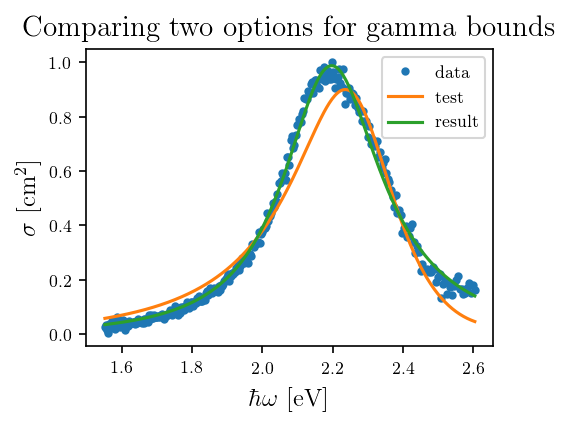

In [168]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([11.6817827 ,  9.56022562,  0.09554153, 40.24119972, 0.95])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[hbarws, AuNP_DFSpec[1],]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#     bounds=(0, np.inf),
    bounds=(
        [5, 5, 0.09, 30, .9],
        [20, 20, 0.1, 50, 1.1]
        )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hbarws, *result['x'][:-1])
norm_fit_result = fit_result/fit_result.max() * result['x'][-1]

higher_damp = result['x'].copy()
higher_damp[2] = 0.22
higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(hbarws, *higher_damp)

data = AuNP_DFSpec[1]
norm_data = data/data.max()

plt.figure(dpi=150)
plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.')
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(hbarws, norm_fit_result,label='result', ls='-')

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Comparing two options for gamma bounds')
plt.legend()

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()

In [146]:
## hbar*gamma resticted to min = 0.09
result['x']

array([ 9.0500746 ,  9.00109957,  0.09      , 43.62519421,  0.98790271])

In [144]:
## hbar*gamma resticted to min = 0.01
result['x']

array([1.03773703e+01, 9.58675792e+00, 1.00000000e-02, 4.62298489e+01,
       9.87512454e-01])

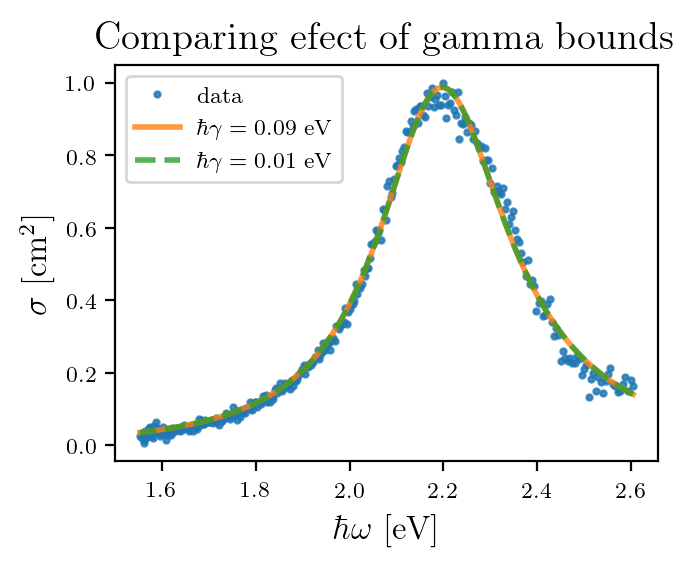

In [189]:
result_pt01 = np.array([ 9.0500746 ,  9.00109957,  0.09      , 43.62519421,  0.98790271])
result_pt09 = np.array([1.03773703e+01, 9.58675792e+00, 1.00000000e-02, 4.62298489e+01,
       9.87512454e-01])

#+++++++++++++++++++++++++++++++++++++++++++++
fit_result_pt01 = ret_fit_scat_1(hbarws, *result_pt01[:-1])
norm_fit_result_pt01 = fit_result/fit_result.max() * result_pt01[-1]

fit_result_pt09 = ret_fit_scat_1(hbarws, *result_pt09[:-1])
norm_fit_result_pt09 = fit_result/fit_result.max() * result_pt09[-1]

data = AuNP_DFSpec[1]
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(hbarws, norm_data, label='data', ls='', marker='o', markersize = 2, alpha=0.8)
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(hbarws, norm_fit_result_pt09 ,label=r'$\hbar\gamma=0.09$ eV', lw=2, alpha=.8, ls='-')
plt.plot(hbarws, norm_fit_result_pt01 ,label=r'$\hbar\gamma=0.01$ eV', lw=2, alpha=.8, ls='--')

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Comparing efect of gamma bounds')
plt.legend()

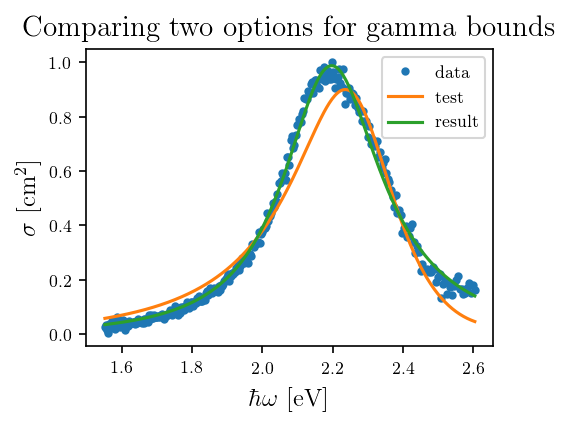

In [168]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([11.6817827 ,  9.56022562,  0.09554153, 40.24119972, 0.95])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[hbarws, AuNP_DFSpec[1],]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#     bounds=(0, np.inf),
    bounds=(
        [5, 5, 0.09, 30, .9],
        [20, 20, 0.1, 50, 1.1]
        )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hbarws, *result['x'][:-1])
norm_fit_result = fit_result/fit_result.max() * result['x'][-1]

higher_damp = result['x'].copy()
higher_damp[2] = 0.22
higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(hbarws, *higher_damp)

data = AuNP_DFSpec[1]
norm_data = data/data.max()

plt.figure(dpi=150)
plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.')
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(hbarws, norm_fit_result,label='result', ls='-')

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Comparing two options for gamma bounds')
plt.legend()

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()

## load the coupled dipole decay rates from BEM's Mie calculator

In [222]:
path_to_sim = (
    "/Users/chair/Documents/MATLAB/sphere_dip_spectrum/")

mie_rates = sio.loadmat(os.path.join(path_to_sim, "sphere_dip_drive_mie_spec.mat"))
mie_rates.keys()

dict_keys(['__header__', '__version__', '__globals__', 'enei', 'rad0', 'tot0'])

Text(0, 0.5, 'Rate enhancement')

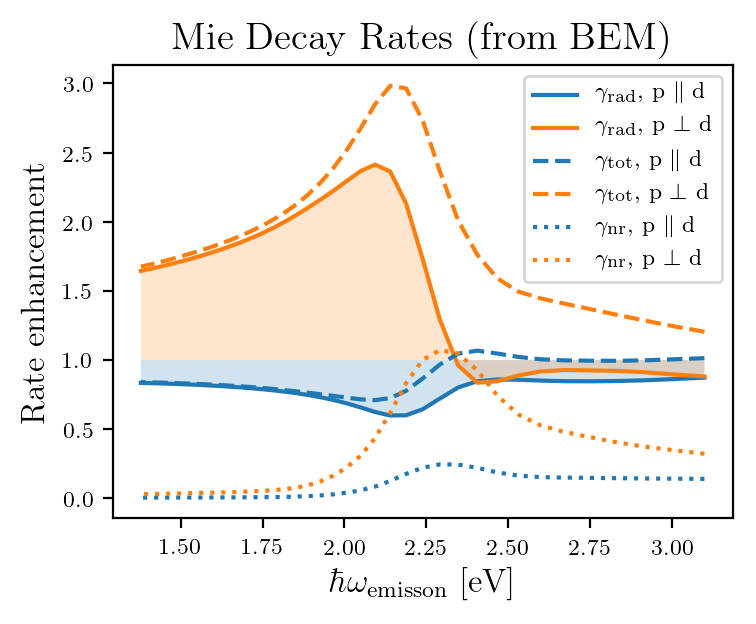

In [263]:
# mie_wavelengths, mie_radiative_rate, mie_decay_rate = mie_rates['enei', 'rad0', 'tot0']
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4,3))


ax.plot(1240/mie_rates['enei'][0], mie_rates['rad0'].T[0], label=r'$\gamma_\mathrm{rad}$, p $\parallel$ d')
ax.fill_between(1240/mie_rates['enei'][0], 1, mie_rates['rad0'].T[0], ALPHA=.2)
ax.plot(1240/mie_rates['enei'][0], mie_rates['rad0'].T[1], label=r'$\gamma_\mathrm{rad}$, p $\perp$ d')
ax.fill_between(1240/mie_rates['enei'][0], 1, mie_rates['rad0'].T[1], ALPHA=.2)

ax.plot(1240/mie_rates['enei'][0], mie_rates['tot0'].T[0], ls='--', c='C0', label=r'$\gamma_\mathrm{tot}$, p $\parallel$ d')
ax.plot(1240/mie_rates['enei'][0], mie_rates['tot0'].T[1], ls='--', c='C1', label=r'$\gamma_\mathrm{tot}$, p $\perp$ d')

ax.plot(
    1240/mie_rates['enei'][0], 
    (mie_rates['tot0'].T[0]-mie_rates['rad0'].T[0]), 
    ls='dotted', 
    c='C0', 
    label=r'$\gamma_\mathrm{nr}$, p $\parallel$ d')
ax.plot(
    1240/mie_rates['enei'][0], 
    (mie_rates['tot0'].T[1]-mie_rates['rad0'].T[1]), 
    ls='dotted', 
    c='C1', 
    label=r'$\gamma_\mathrm{nr}$, p $\perp$ d')


ax.legend()
ax.set_title('Mie Decay Rates (from BEM)')
ax.set_xlabel('$\hbar\omega_{\mathrm{emisson}}$ [eV]')
ax.set_ylabel('Rate enhancement')


I think I can use these as my enhancement factors: $g_r(\omega)$ and $g_{ET}(\omega)$, next up is to integral normalized the fluorescence spectrum

In [266]:
import scipy.integrate as integrate

Text(0.5, 1.0, 'Integral normalized emission spectrum')

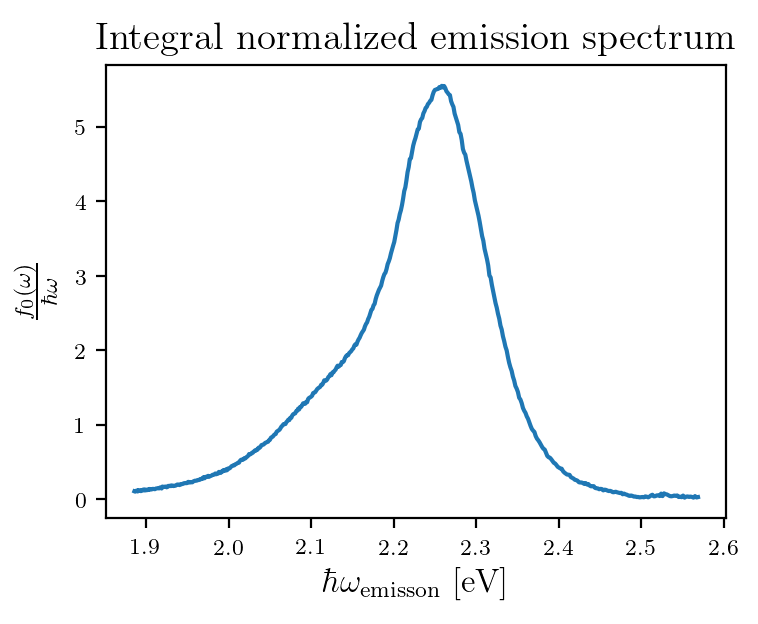

In [292]:
mol_em_norm = integrate.simps(R6G_spectrum[1], 1240/R6G_spectrum[0,])
plt.figure(dpi=200, figsize=(4,3))
plt.plot(1240/R6G_spectrum[0], R6G_spectrum[1]/mol_em_norm)
plt.ylabel(r'$\frac{f_0(\omega)}{\hbar\omega}$')
plt.xlabel('$\hbar\omega_{\mathrm{emisson}}$ [eV]')
plt.title('Integral normalized emission spectrum')

In [285]:
q_yield = 0.9

In [312]:
## Calculate the total rates from the Ringler paper
from scipy import interpolate 
# f = interpolate.interp1d(x, y)

gr_of_hbaromega = interpolate.interp1d(
    1240/mie_rates['enei'][0], mie_rates['rad0'].T[0])
f0_of_hbaromega = interpolate.interp1d(
    1240/R6G_spectrum[0], R6G_spectrum[1]/mol_em_norm)

gET_of_hbaromega = interpolate.interp1d(
    1240/mie_rates['enei'][0], 
    (mie_rates['tot0'].T[0]-mie_rates['rad0'].T[0]),)

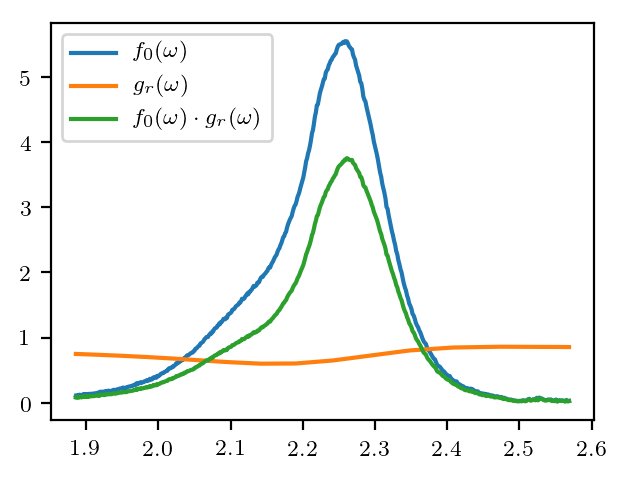

In [307]:
plt.plot(
    1240/R6G_spectrum[0], 
    R6G_spectrum[1]/mol_em_norm,
    label='$f_0(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    gr_of_hbaromega(1240/R6G_spectrum[0]), label=r'$g_r(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    gr_of_hbaromega(1240/R6G_spectrum[0]) * f0_of_hbaromega(1240/R6G_spectrum[0]),
    label='$f_0(\omega) \cdot g_r(\omega)$'
    )
plt.legend()

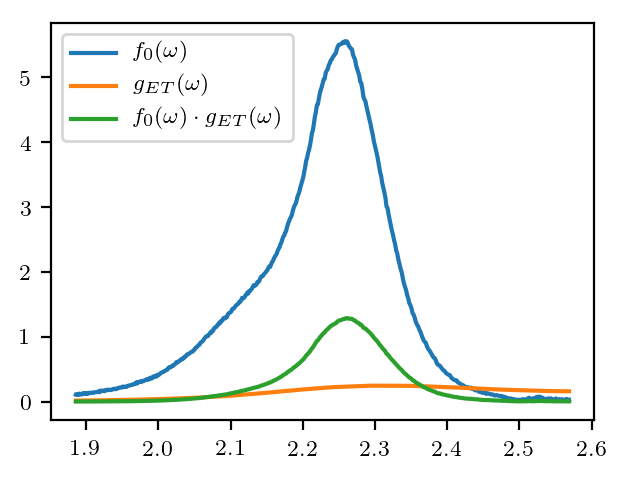

In [316]:
plt.plot(
    1240/R6G_spectrum[0], 
    R6G_spectrum[1]/mol_em_norm,
    label='$f_0(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    gET_of_hbaromega(1240/R6G_spectrum[0]), label=r'$g_{ET}(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    gET_of_hbaromega(1240/R6G_spectrum[0]) * f0_of_hbaromega(1240/R6G_spectrum[0]),
    label='$f_0(\omega) \cdot g_{ET}(\omega)$'
    )
plt.legend()

In [313]:
gamma_r_on_gamma_r0, gamma_r_on_gamma_r0_error = integrate.quad(
    lambda hbarw: gr_of_hbaromega(hbarw) * f0_of_hbaromega(hbarw), 
    np.min(1240/R6G_spectrum[0]), 
    np.max(1240/R6G_spectrum[0])
    )

gamma_ET_on_gamma_r0, gamma_ET_on_gamma_r0_error = integrate.quad(
    lambda hbarw: gET_of_hbaromega(hbarw) * f0_of_hbaromega(hbarw), 
    np.min(1240/R6G_spectrum[0]), 
    np.max(1240/R6G_spectrum[0])
    )


/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.
/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from spl

In [311]:
gamma_r_on_gamma_r0

0.6755241500305003

In [314]:
gamma_ET_on_gamma_r0

0.1917152643519352

In [318]:
def g_em(hbarw, nu_0):
    """ Takes vector of energies and the internal quantum yield of the 
        dye: nu_0.
        """
    g = gr_of_hbaromega(hbarw) / (
        nu_0 * (
            gamma_r_on_gamma_r0
            +
            gamma_ET_on_gamma_r0
            +
            (1/nu_0 - 1)) 
        )
    return g

Text(0.5, 1.0, 'emission emhancement')

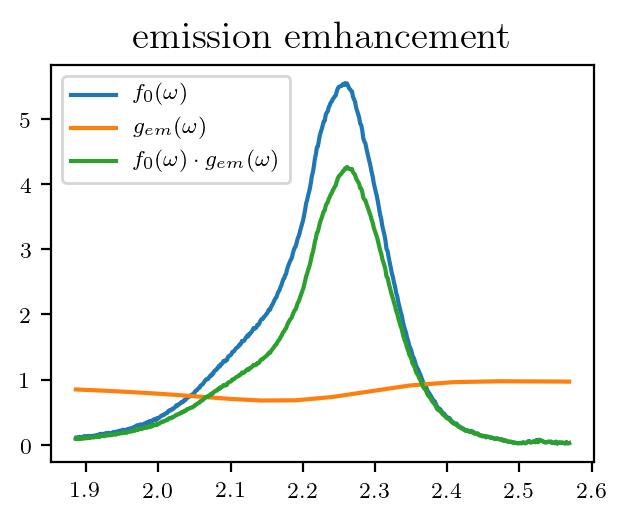

In [350]:
plt.plot(
    1240/R6G_spectrum[0], 
    R6G_spectrum[1]/mol_em_norm,
    label='$f_0(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    g_em(1240/R6G_spectrum[0], q_yield), label=r'$g_{em}(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    g_em(1240/R6G_spectrum[0], q_yield) * R6G_spectrum[1]/mol_em_norm, 
    label=r'$f_0(\omega) \cdot g_{em}(\omega)$'
    )

plt.legend()
plt.title('emission emhancement')

In [327]:
thermo_fisher_dye_data = np.loadtxt('BODIPY R6G.csv', skiprows=1, delimiter=',')

Text(0.5, 1.0, 'R6G emission spectrum')

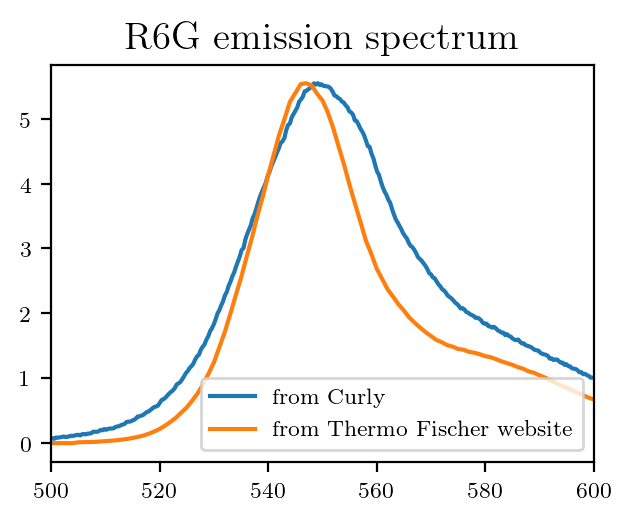

In [344]:
plt.plot(
    R6G_spectrum[0], 
    R6G_spectrum[1]/mol_em_norm,
    label='from Curly'
    )
TF_exc_spec_norm_constant = integrate.simps(
    thermo_fisher_dye_data.T[1], 1240/thermo_fisher_dye_data.T[0][-1::-1]
    )
TF_emi_spec_norm_constant = integrate.simps(
    thermo_fisher_dye_data.T[2], 1240/thermo_fisher_dye_data.T[0][-1::-1]
    )
# plt.plot(
#     thermo_fisher_dye_data.T[0], 
#     thermo_fisher_dye_data.T[1]/TF_exc_spec_norm_constant
#     )
plt.plot(
    thermo_fisher_dye_data.T[0], 
    thermo_fisher_dye_data.T[2]/thermo_fisher_dye_data.T[2].max()*(R6G_spectrum[1]/mol_em_norm).max(),
    label='from Thermo Fischer website')
plt.xlim([500,600])
plt.legend()
plt.title('R6G emission spectrum')

In [348]:
max_excitation_wavelength = thermo_fisher_dye_data.T[0][np.argmax(thermo_fisher_dye_data.T[1])]
